In [1]:
import numpy as np
import tensorflow as tf
import librosa
import os
import itertools
from jupyterplot import ProgressPlot
import IPython
import math
import matplotlib.pyplot as plt

# Hack to get it to work with RTX 2000 cards
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


2021-11-23 13:08:22.927911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 13:08:22.968297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 13:08:22.968691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Enumerate dataset files
dataset_dir = './Baggins_Music/'
music_filenames = os.listdir(dataset_dir)

In [3]:
# Load a file to play with
song_np, sr = librosa.load(dataset_dir+music_filenames[0], mono=False)
song_np = np.transpose(song_np)

/home/bij/anaconda3/envs/MusicAnalyzer/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
# Papers and resources
# WaveNet paper https://arxiv.org/pdf/1609.03499.pdf
# WaveNet AutoEncoder paper (instrument decomp): https://arxiv.org/pdf/1704.01279.pdf
# NSynth: https://magenta.tensorflow.org/nsynth
# WaveNet implementation: https://github.com/ibab/tensorflow-wavenet

In [4]:
class AudioLayer(tf.keras.layers.Layer):
    def __init__(self, powers=8, activation='sigmoid', halve=True):
        '''
        Halves the temporal dimension
        Expects tensor of shape (bs, T, chans)
        '''
        super(AudioLayer, self).__init__()
        self.sub_lyrs = []
        self.act = activation
        self.halve = halve
        for lyr_idx in range(powers):
            dil_rate = 2**lyr_idx
            self.sub_lyrs += [tf.keras.layers.Conv1D(filters=1, 
                                                     kernel_size=5, 
                                                     strides=1, 
                                                     padding='same', 
                                                     dilation_rate=dil_rate, 
                                                     activation=self.act)]
        self.pool_lyr = tf.keras.layers.MaxPool1D()

    def call(self, x):
        outputs = []
        for idx,lyr in enumerate(self.sub_lyrs):
            outputs += [tf.squeeze(lyr(x))]
            
        stacked = tf.stack(outputs, axis=-1)
        if(self.halve):
            pooled = self.pool_lyr(stacked)
        else:
            pooled = stacked
        #x_interlaced = tf.concat([x[:, 0::2], x[:, 1::2]], axis=-1)
        x_interlaced = None
        return pooled, x_interlaced
        
    

In [33]:
class AudioAutoEncoder(tf.keras.Model):

    def __init__(self, input_dur=1, sample_rate=22050):
        '''
        input_dur: duration of input (in seconds)
        sample_rate: sampling frequency of input audio (in hz) 
        '''
        super(AudioAutoEncoder, self).__init__()
        self.sample_rate = sample_rate
        # Length of the hidden representation
        #self.z_len = 128
        self.z_len = 1024
        # Calculate the size of the input
        self.num_splits = int(math.log2(sample_rate*input_dur/self.z_len) + 1.5)
        self.input_len = self.z_len*2**self.num_splits
        print('Making model w/ num_splits: ', self.num_splits, '\tand input len: ', self.input_len)
        # Activation function to use
        self.act = 'sigmoid'

        # A loss function
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        #self.loss_fn = tf.keras.losses.MeanAbsoluteError()
        # An optimizer
        #self.optim = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD')
        self.optim = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
        
        self.enc_lyrs = []
        for split_idx in range(self.num_splits):
            self.enc_lyrs += [AudioLayer()]
        
        self.dec_lyrs = []
        for dec_idx in range(self.num_splits):
            self.dec_lyrs += [AudioLayer(halve=False)]
        self.last_lyr = tf.keras.layers.Conv1D(filters=2, 
                                                 kernel_size=1, 
                                                 strides=1, 
                                                 padding='same', 
                                                 dilation_rate=1, 
                                                 activation=self.act)
        

    def encoder(self, x):
        for idx,lyr in enumerate(self.enc_lyrs):
            x, x_bypass = lyr(x)
        return x
    
    def decoder(self, x):
        # Blow it up back to the original size
        repeat_num = int(self.input_len/self.z_len)
        x = tf.repeat(x, repeat_num, axis=1)
        for idx,lyr in enumerate(self.dec_lyrs):
            x, x_bypass = lyr(x)
        x = self.last_lyr(x)
        return x
    
    def calc_loss(self, x_hat, x):
        loss = self.loss_fn(x, x_hat)
        return loss
        
    def call(self, inputs):
        z = self.encoder(inputs)
        x_hat = self.decoder(z)
        # Zero center and scale 
        x_hat = 2.0*x_hat - 1.0
    
        return x_hat

# Instantiate one
auto_encoder = AudioAutoEncoder(sample_rate=sr)

Making model w/ num_splits:  5 	and input len:  32768


In [ ]:
class AudioAutoEncoder(tf.keras.Model):

    def __init__(self, input_dur=1, sample_rate=22050):
        '''
        input_dur: duration of input (in seconds)
        sample_rate: sampling frequency of input audio (in hz) 
        '''
        super(AudioAutoEncoder, self).__init__()
        self.sample_rate = sample_rate
        # Length of the hidden representation

        # Calculate the size of the input
        self.input_len = self.sample_rate*input_dur
        
        # Activation function to use
        self.act = 'sigmoid'

        # A loss function
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        #self.loss_fn = tf.keras.losses.MeanAbsoluteError()
        # An optimizer
        #self.optim = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0, nesterov=False, name='SGD')
        self.optim = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
        
        self.enc_lyrs = []
        self.enc_lyrs += [tf.keras.layers.Conv1D(filters=2, 
                                                 kernel_size=5, 
                                                 strides=1, 
                                                 padding='same', 
                                                 dilation_rate=1, 
                                                 activation=self.act)]
        
        self.dec_lyrs = []
        self.last_lyr = tf.keras.layers.Conv1D(filters=2, 
                                                 kernel_size=5, 
                                                 strides=1, 
                                                 padding='same', 
                                                 dilation_rate=1, 
                                                 activation=self.act)
        

    def encoder(self, x):
        for idx,lyr in enumerate(self.enc_lyrs):
            x = lyr(x)
        return x
    
    def decoder(self, x):
        for idx,lyr in enumerate(self.dec_lyrs):
            x = lyr(x)
        x = self.last_lyr(x)
        return x
    
    def calc_loss(self, x_hat, x):
        loss = self.loss_fn(x, x_hat)
        return loss
        
    def call(self, inputs):
        z = self.encoder(inputs)
        x_hat = self.decoder(z)
        # Zero center and scale 
        x_hat = 2.0*x_hat - 1.0
    
        return x_hat

# Instantiate one
auto_encoder = AudioAutoEncoder(sample_rate=sr)

In [6]:
# Prep the dataset
ds_num_samples = int(len(song_np)/auto_encoder.input_len)
song_ds = song_np[0:auto_encoder.input_len*ds_num_samples]
song_ds = np.reshape(song_ds, (ds_num_samples, -1, 2))
song_ds.shape

(2094, 32768, 2)

In [7]:
# Smooths input using mean window (should change to exponential smoothing soon)
class Smoother:
    def __init__(self, alpha=0.1, skip_steps=1):
        self.step_count = 0
        self.s_last = None
        self.alpha = alpha
        self.skip_steps = skip_steps
    def smooth(self, s_now):
        if(self.s_last):
            self.s_last = s_now*self.alpha + self.s_last*(1-self.alpha)
        else:
            self.s_last = s_now
        
        self.step_count += 1
        
        if(self.step_count % self.skip_steps == 0):
            return self.s_last

In [34]:
# Run the training loop 

#batch_size = 8
batch_size = 16
#batch_size = 64

# For plotting loss
pp = ProgressPlot()
# Smoother for smoothing
smoother = Smoother(alpha=0.05, skip_steps=1)

# Train the autoencoder
for step in itertools.count():
    # Get the batch
    batch_idxs = np.random.randint(0, ds_num_samples, size=batch_size)
    x = song_ds[batch_idxs]

    # Put batch through model
    
    with tf.GradientTape() as t:
        x_hat = auto_encoder(x)
        # Get Loss
        loss_recon = auto_encoder.calc_loss(x_hat, x)
        loss_smooth = smoother.smooth(loss_recon.numpy())
        if(loss_smooth):
            pp.update(float(loss_smooth))
        #print('Step {0:8d}\tLoss: {1:3.4f}'.format(step, loss_recon.numpy()))
        grads = t.gradient(loss_recon, auto_encoder.variables)
        
    # Backprop grads
    auto_encoder.optim.apply_gradients(zip(grads, auto_encoder.variables))
    
    #if(step >= 2000):
    #    break
    
    
    

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [35]:
# Get some music from the dataset and test it
start_time = 500
duration = 20
start_idx = int(start_time*sr)
end_idx = int((start_time+duration)*sr)

x = song_np[start_idx:end_idx, :]
x_hat = auto_encoder(np.reshape(x, (duration, -1, 2)))
x_hat = tf.reshape(x_hat, (-1, 2))

# Format them for playback
x = np.transpose((x*32768).astype(np.int16))
x_hat = np.transpose((x_hat.numpy()*32768).astype(np.int16))
        

In [36]:
# Play original
IPython.display.Audio(data=x, rate=sr)

In [37]:
print(x_hat.shape)
IPython.display.Audio(data=x_hat, rate=sr)

(2, 440960)


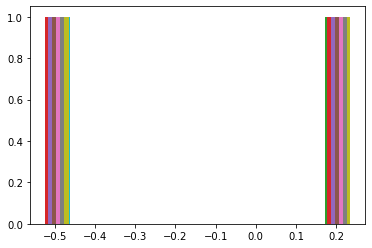

In [25]:
import matplotlib.pyplot as plt
rand_idxs = np.random.randint(0, x_hat.shape[1], size=1000)
plt.hist(x_hat[:, rand_idxs].astype(float)/32768)
plt.show()

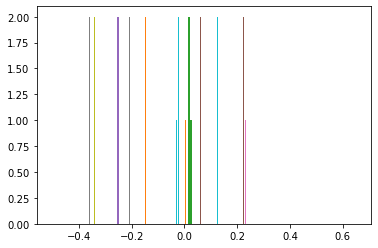

In [26]:
plt.hist(x[:, rand_idxs].astype(float)/32768)
plt.show()

In [27]:
np.sum(x_hat[0, :] > 25)/x_hat[0,:].size

1.0

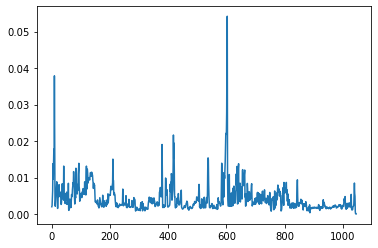

In [52]:
# Plot error over time for the entire set
song_ds.shape
bs = 2
errors = []
sketchy_audio = []
for i in range(0, len(song_ds), bs):
    sample = song_ds[i:i+bs]
    x_hat = auto_encoder(sample)
    loss = auto_encoder.calc_loss(sample, x_hat)
    errors += [loss]
    if(loss > 0.02):
        sketchy_audio += [sample]
plt.plot(errors)
plt.show()

In [61]:
#print(.shape)
IPython.display.Audio(data=np.transpose(sketchy_audio[0][1]), rate=sr)